<a href="https://colab.research.google.com/github/euguroglu/Machine-Learning-Projects/blob/master/RNN_Pytorch_Industrial_Production_Gas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [2]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


## Data visualization

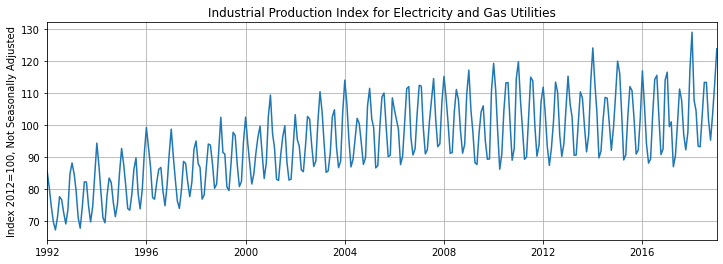

In [4]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

## 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [5]:

y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [6]:
# Run the code below to check your results:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


## 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_set.reshape(-1,1))
train_norm = scaler.transform(train_set.reshape(-1,1))

In [8]:
# Run the code below to check your results:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 85.556
First item, scaled:  [-0.4091274]


## 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [9]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [10]:
train_data = input_data(train_norm,window_size)

In [11]:
print(f'Train_data: {len(train_data)}')  # should equal 301

Train_data: 301


## 4. Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [36]:
class LSTM(nn.Module):

  def __init__(self,input_size=1,hidden_size=64,out_size=1):

    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size,hidden_size)
    self.linear = nn.Linear(hidden_size,out_size)
    self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))

  def forward(self,seq):

    lstm_out,self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
    pred = self.linear(lstm_out.view(len(seq),-1))

    return pred[-1]

In [37]:
torch.manual_seed(101)
model = LSTM()
model

LSTM(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## 5. Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

### 6. Train the model
Don't worry about tracking loss values, displaying results, or validating the test set. Just train the model through 50 epochs. We'll evaluate the trained model in the next step.<br>
OPTIONAL: print something after each epoch to indicate training progress.

In [39]:
epochs = 50

import time
start_time = time.time()

for i in range(epochs):
  for seq,y_train in train_data:
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))

    y_pred = model(seq)

    loss = criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()

  print('Epoch: {} Loss: {}'.format(i,loss))

total_time = time.time() - start_time
print(total_time/60)

Epoch: 0 Loss: 0.7314830422401428
Epoch: 1 Loss: 0.32224392890930176
Epoch: 2 Loss: 0.24065648019313812
Epoch: 3 Loss: 0.2275601625442505
Epoch: 4 Loss: 0.2115359902381897
Epoch: 5 Loss: 0.19906578958034515
Epoch: 6 Loss: 0.19067460298538208
Epoch: 7 Loss: 0.18480707705020905
Epoch: 8 Loss: 0.1796238124370575
Epoch: 9 Loss: 0.174419566988945
Epoch: 10 Loss: 0.16898852586746216
Epoch: 11 Loss: 0.16325688362121582
Epoch: 12 Loss: 0.15732835233211517
Epoch: 13 Loss: 0.1513940840959549
Epoch: 14 Loss: 0.14566262066364288
Epoch: 15 Loss: 0.14030809700489044
Epoch: 16 Loss: 0.13544121384620667
Epoch: 17 Loss: 0.1311032474040985
Epoch: 18 Loss: 0.12727928161621094
Epoch: 19 Loss: 0.12391797453165054
Epoch: 20 Loss: 0.12095394730567932
Epoch: 21 Loss: 0.11832569539546967
Epoch: 22 Loss: 0.11598344147205353
Epoch: 23 Loss: 0.11389030516147614
Epoch: 24 Loss: 0.11202088743448257
Epoch: 25 Loss: 0.11036178469657898
Epoch: 26 Loss: 0.10891450196504593
Epoch: 27 Loss: 0.10769789665937424
Epoch: 28 

In [40]:
train_data

[(tensor([-0.4091, -0.5761, -0.7607, -0.9201, -1.0000, -0.8686, -0.6636, -0.6944,
          -0.8313, -0.9396, -0.7939, -0.4343]), tensor([-0.3223])),
 (tensor([-0.5761, -0.7607, -0.9201, -1.0000, -0.8686, -0.6636, -0.6944, -0.8313,
          -0.9396, -0.7939, -0.4343, -0.3223]),
  tensor([-0.4340])),
 (tensor([-0.7607, -0.9201, -1.0000, -0.8686, -0.6636, -0.6944, -0.8313, -0.9396,
          -0.7939, -0.4343, -0.3223, -0.4340]), tensor([-0.5999])),
 (tensor([-0.9201, -1.0000, -0.8686, -0.6636, -0.6944, -0.8313, -0.9396, -0.7939,
          -0.4343, -0.3223, -0.4340, -0.5999]), tensor([-0.8734])),
 (tensor([-1.0000, -0.8686, -0.6636, -0.6944, -0.8313, -0.9396, -0.7939, -0.4343,
          -0.3223, -0.4340, -0.5999, -0.8734]), tensor([-0.9827])),
 (tensor([-0.8686, -0.6636, -0.6944, -0.8313, -0.9396, -0.7939, -0.4343, -0.3223,
          -0.4340, -0.5999, -0.8734, -0.9827]), tensor([-0.7669])),
 (tensor([-0.6636, -0.6944, -0.8313, -0.9396, -0.7939, -0.4343, -0.3223, -0.4340,
          -0.599

### 9. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [41]:
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])
  with torch.no_grad():

    model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))

    preds.append(model(seq).item()) 

In [42]:
# Run the code below to check your results:
preds[window_size:]

[0.2540278434753418,
 -0.002775155007839203,
 -0.34294819831848145,
 -0.21167579293251038,
 0.23918873071670532,
 0.48914825916290283,
 0.24707987904548645,
 -0.08662215620279312,
 -0.25781765580177307,
 0.02258601039648056,
 0.5441880822181702,
 0.6110795736312866]

## 10. Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [43]:

true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [44]:

true_predictions

array([[105.95763959],
       [ 98.05722374],
       [ 87.59197015],
       [ 91.63050007],
       [105.50112171],
       [113.19100162],
       [105.74388894],
       [ 95.47771268],
       [ 90.21096873],
       [ 98.83744732],
       [114.88427426],
       [116.94215754]])

## BONUS EXERCISE: Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

In [46]:
df.index
x = np.arange('2018-02-01','2019-02-01',dtype='datetime64[M]')

In [47]:
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

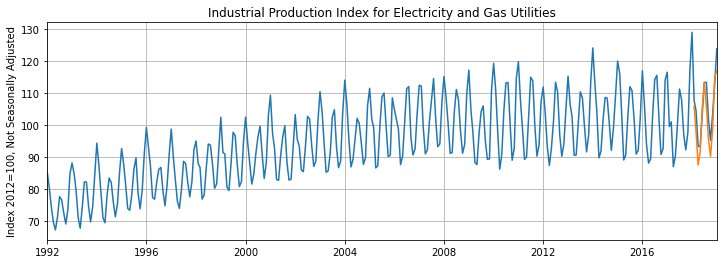

In [50]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

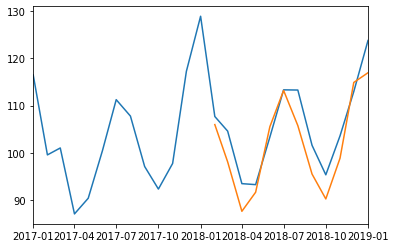

In [52]:
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.autoscale(axis='x',tight=True)
plt.show()